# Lab 2: Set Covering with Evolution Algorithm

Given a number $N$ and some lists of integers $P = (L_0, L_1, L_2, ..., L_n)$, <br>
determine, if possible, $S = (L_{s_0}, L_{s_1}, L_{s_2}, ..., L_{s_n})$<br>
such that each number between $0$ and $N-1$ appears in at least one list<br>
<br>
$forall \ n \ in \ [0, N-1] \ exists \ i : n \ in \ L_{s_i}$<br>
<br>
and that the total numbers of elements in all $L_{s_i}$ is minimum.

<b>Individual: Candidate solution</b><br>
Set of used lists. Every list is represented by an unsigned integer, formed by the juxtaposition 0's (if that number is not in the list) and 1's (if it is in the list). Ex. [0, 2, 3] becomes 01101 = 13

<b>Population: Set of candidate solutions</b><br>
List of the lists (represented by the unsigned integers)

<b>Fitness: Ability to solve the problem</b><br>
Calculate $(2^N - 1) - (list1 | list2 | ...)$ -> (<i>'|'</i> is a <i>'bitwise or'</i>)<br>
Then, count the number of 1's of its binary representation.

<b>Generations: Sequence of steps</b><br>
Random changes, Evaluation, Next generation

<b>Cross-over</b><br>
Given two sets of numbers, take half of the first one, and half of the second one

<b>Mutation</b><br>
Given a set of numbers, change one element of the set with one by the list of all numbers

In [77]:
import random
import logging
from collections import namedtuple
from functools import reduce
from matplotlib import pyplot as plt

In [78]:
def problem(N, seed=None):
    random.seed(seed)
    return [
        list(set(random.randint(0, N - 1) for n in range(random.randint(N // 5, N // 2))))
        for n in range(random.randint(N, N * 5))
    ]

In [79]:
logging.basicConfig(format="%(message)s", level=logging.INFO)

In [211]:
PROBLEM_SIZE = 1000 # N
POPULATION_SIZE = 10
OFFSPRING_SIZE = 5

NUM_GENERATIONS = 100

In [81]:
# count the number of 1's in a number
def bitcount(n):
    count = 0
    while n > 0:
        count = count + 1
        n = n & (n-1)
    return count

# convert a list to an int. Ex. [0, 2, 3] becomes 01101 = 13
def list_to_int(list_):
    list_[0] = 2**list_[0]
    return reduce(lambda x, y: x | 2**y, list_)

# creates the lists, converts them to integers, and returns a set
def get_all_lists(N):
    return list(set(map(lambda l: list_to_int(l), problem(N))))

In [112]:
Individual = namedtuple("Individual", ["genome", "fitness"])


# fitness function
def get_fitness(genome):
    max = 2**PROBLEM_SIZE - 1
    current = reduce(lambda x, y: x | y, genome)
    return bitcount(max - current)


# returns individuals with min fitness (the fittest) but still random
def tournament(population, tournament_size=2):
    return min(random.choices(population, k=tournament_size), key=lambda i: i.fitness)


# merge two individuals
def cross_over(g1, g2):
    return list(set(g1 + g2))


# replace a list in the individual with one "original" list
def mutation(g):
    point = random.randint(0, len(g))
    random_ = random.choice(all_lists)
    return list(set(g[:point] + ([random_]) + g[point + 1 :]))

## Initial Population

In [216]:
all_lists = get_all_lists(PROBLEM_SIZE)
population = list(map(lambda l: Individual([l], get_fitness([l])), all_lists))[:POPULATION_SIZE]
logging.info(f"init: pop_size={len(population)}; min={min(population, key=lambda i: i.fitness)[1]}")

init: pop_size=10; min=619


## Evolution

In [217]:
fitness_log = [(0, i.fitness) for i in population]

found = False
num_gen = 0

for g in range(NUM_GENERATIONS):
    if found:
        break
    offspring = list()
    for i in range(OFFSPRING_SIZE):
        if random.random() < 0.3:
            p = tournament(population)
            o = mutation(p.genome)
        else:
            p1 = tournament(population)
            p2 = tournament(population)
            o = cross_over(p1.genome, p2.genome)
        f = get_fitness(o)
        fitness_log.append((g + 1, f))
        offspring.append(Individual(o, f))
        if f == 0:
            found = True
            num_gen = g
            logging.info(f"Found a solution for N={PROBLEM_SIZE}")
            logging.info(f"Fitness calls: {len(fitness_log) - POPULATION_SIZE}")
            logging.info(f"Number of generations: {num_gen}")
            #logging.info(f"Solution: {o}")
            #logging.info(f"Coverage: {reduce(lambda x, y: x | y, o)} -> Should be {2**PROBLEM_SIZE - 1}!")
            break
    for goff in offspring:
        if goff not in population:
            population.append(goff)
    population = sorted(population, key=lambda i: i.fitness)[:POPULATION_SIZE]

Found a solution for N=1000
Fitness calls: 128
Number of generations: 25


## Performance Evaluation

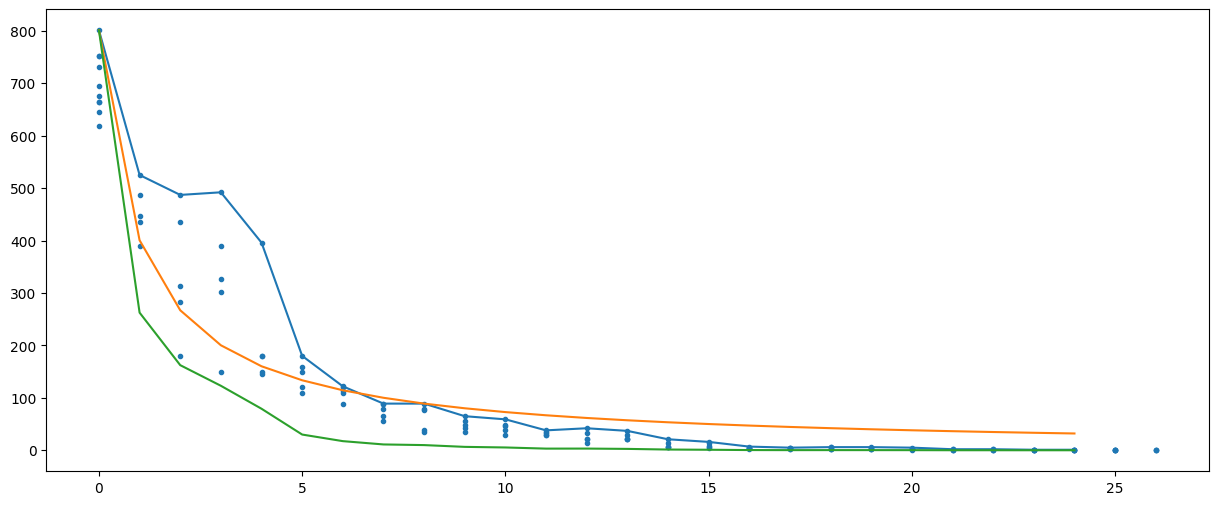

In [218]:
off_line = [max(f[1] for f in fitness_log if f[0] == x) / (x + 1) for x in range(num_gen)]
on_line = [max(f[1] for f in fitness_log if f[0] <= x) / (x + 1) for x in range(num_gen)]
gen_best = [max(f[1] for f in fitness_log if f[0] == x) for x in range(num_gen)]

plt.figure(figsize=(15, 6))
plt.scatter([x for x, _ in fitness_log], [y for _, y in fitness_log], marker=".")
plt.plot([x for x, _ in enumerate(gen_best)], [y for _, y in enumerate(gen_best)])
plt.plot([x for x, _ in enumerate(on_line)], [y for _, y in enumerate(on_line)])
plt.plot([x for x, _ in enumerate(off_line)], [y for _, y in enumerate(off_line)])